# Chemistry — Compound Lookups

Several Python packages exist that simplify the process of looking compounds and their chemical structure.

For example, we can look-up compounds by name or structure, which allows us to create a readable sequence of steps that allows us obtain the structure of a compound, and various properties of it, simply by starting with its common name.

With a representation of the structure to hand, we can then visualise its structure as demonstrated in a later section.

This allows us in part to create one-piece workflows where rich outputs are generated from (potentially hidden) generative scripts contained within the source document.

Through being able to look up properties of materials, we can also generate factual statements about them or generate quizzes or opportunities for self-text activities around them.

## `pubchempy`

The [`pubchempy`](https://pubchempy.readthedocs.io/en/latest/) package provides a Python interface to [PubChem](https://pubchem.ncbi.nlm.nih.gov/), a  freely accessible chemical information lookup service that allows for the searching of chemicals by name, lookups of molecular formulas and structures using conventional representations such as a SMILES representation. (Chemicals can also be looked up via their SMILES string.)

```{admonition}SMILES
SMILES ([*Simplified molecular-input line-entry system*](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system)) is a simple text format for desctibing molecular structure.

Related: [SMILES tutorial](https://www.epa.gov/sites/production/files/2015-05/documents/appendf.pdf(
```

Packages like `pubchempy` can be used in conjunction with visualisers such as `py3Dmol` to look up a molecule by name (using `pubchempy`) and then display its structure as an interactive 3D model (using `py3Dmol`).

In [1]:
%%capture
try:
    import pubchempy as pcp
except:
    %pip install --upgrade pubchempy

Import the base package:

In [2]:
import pubchempy as pcp

We can look up a chemical by name, select the first result, and then generate the canonical or isomeric SMILES representation:

In [3]:
ethanol = pcp.get_compounds('ethanol', 'name')[0]
ethanol.canonical_smiles, ethanol.isomeric_smiles

('CCO', 'CCO')

We can also look up compounds by formula. If required, responses from look-ups can be returned as *pandas* dataframes:

In [4]:
nitric_acid_df = pcp.get_compounds('HNO3', 'formula', as_dataframe=True)[:3]

nitric_acid_df[['iupac_name', 'molecular_formula', 'canonical_smiles', 'inchi']]

,iupac_name,molecular_formula,canonical_smiles,inchi
cid,,,,
944,nitric acid,HNO3,[N+](=O)(O)[O-],"InChI=1S/HNO3/c2-1(3)4/h(H,2,3,4)"
123349,hydroxy nitrite,HNO3,N(=O)OO,InChI=1S/HNO3/c2-1-4-3/h3H
12025424,deuterio nitrate,HNO3,[N+](=O)(O)[O-],"InChI=1S/HNO3/c2-1(3)4/h(H,2,3,4)/i/hD"


Round tripping is possible by looking up a chemical using its SMILES representation and then displaying the name, for example.

In [5]:
#Look up by SMILES string
compound = pcp.get_compounds('CCO', 'smiles')[0]
compound.iupac_name

'ethanol'

We can also use other codes for the lookup:

In [6]:
pcp.get_compounds("InChI=1S/HNO3/c2-1(3)4/h(H,2,3,4)","inchi",
                  as_dataframe=True).iloc[0]['iupac_name']

'nitric acid'

The retrieved representation described a wide range of useful informational properties associated with the compound.

For example, looking up the chemical formula (this is described as the *molecular formula* altough I think it's actually the *empirical formula*?):

In [7]:
compound.molecular_formula

'C2H6O'

A simple, literally stated formula can be rendered using MathJax if the `mhchem` package is imported.

```{note}
Support for rendering chemical notation using inline LaTeX markup is enabled by including the following installation requirement into a markdown cell: `$$\require{mhchem}$$`.

Formulas can then be rendered using the an inline LaTeX invocation of the form `$\ce{C2H6O}$`.
```

$$\require{mhchem}$$ 
For example: $\ce{C2H6O}$

We can also lookup various properties of the compound and use that as the basis of a custom display outputter for the `pubchempy.Compound` object.

In [8]:
# Create a function to display compound properties
def pcp_compound_properties(compound):
    """Display various compound properties."""
    properties = []
    properties.append(f'Name: <strong>{compound.iupac_name}</strong>')
    properties.append(f'Formula: <strong>{compound.molecular_formula}</strong>')
    properties.append(f'Common synonyms: <strong>{", ".join(compound.synonyms[:3])}</strong>')
    properties.append(f'SMILES: <strong>{compound.canonical_smiles}</strong>')
    properties.append(f'cid:  <strong>{compound.cid}</strong>')
    properties.append(f'inchi:  <strong>{compound.inchi}</strong>')
    properties.append(f'Molecular weight: <strong>{compound.molecular_weight}</strong>')

    return '<br/>'.join(properties)

# Get a reference to the Compound class
from pubchempy import Compound

# Create a custom formatter for the class
# https://ipython.readthedocs.io/en/stable/config/integrating.html 
html_formatter = get_ipython().display_formatter.formatters['text/html']
html_formatter.for_type(Compound, pcp_compound_properties);

That code can easily be added to a package or included and hidden within source document.

Now if we call the compound we get a prettified, custom output for it:

In [9]:
compound

Compound(702)

## `chembl_webresource_client`

The [ `chembl_webresource_client`](https://github.com/chembl/chembl_webresource_client) package provides a Python interface to [ChEMBL](https://www.ebi.ac.uk/chembl/) to support the lookup of chemical compounds by common name.

In [10]:
%%capture
try:
    import chembl_webresource_client
except:
    %pip install --upgrade chembl_webresource_client

Import the package and create a reference for a molecule lookup:

In [11]:
from chembl_webresource_client.new_client import new_client

molecule = new_client.molecule

In [12]:
aspirin = molecule.search('aspirin')

for r in aspirin:
    pref_name = r['pref_name']
    if pref_name is not None:
        print(pref_name)

ASPIRIN
ASPIRIN EUGENOL ESTER
ASPIRIN DL-LYSINE


We can also look-up syonyms of the compound, which might include trade names:

In [13]:
aspirin = [r for r in res if r['pref_name']=='ASPIRIN'][0]
aspirin['molecule_synonyms'][:5]

NameError: name 'res' is not defined

In [108]:
from IPython.display import HTML

# Create a function to display compound properties
def chembl_wrc_molecule_properties(molecule):
    """Display various compound properties."""
    properties = []
    _wikipedia_name =  [c['xref_id'] for c in molecule['cross_references'] if c["xref_src"]=='Wikipedia']
    _wikipedia_name = '' if not _wikipedia_name else _wikipedia_name[0]
    properties.append(f'Name: <strong>{molecule["pref_name"]}</strong>')
    properties.append(f'Common Wikipedia (common) name: <strong>{_wikipedia_name}</strong>')
    properties.append(f'Formula: <strong>{molecule["molecule_properties"]["full_molformula"]}</strong>')
    properties.append(f'Species: <strong>{molecule["molecule_properties"]["molecular_species"]}</strong>')
    properties.append(f'SMILES: <strong>{molecule["molecule_structures"]["canonical_smiles"]}</strong>')
    properties.append(f'inchi:  <strong>{molecule["molecule_structures"]["standard_inchi"]}</strong>')
    properties.append(f'CHEMBL id:  <strong>{molecule["molecule_chembl_id"]}</strong>')
    properties.append(f'Therapeutic flag: <strong>{molecule["therapeutic_flag"]}</strong>')
    properties.append(f'First approval: <strong>{molecule["first_approval"]}</strong>')

    return HTML('<br/>'.join(properties))

In [109]:
chembl_wrc_molecule_properties(aspirin)

Lookup a molecule using SMILES:

In [110]:
from chembl_webresource_client.new_client import new_client

molecule = new_client.molecule
ethanol_chembl = molecule.get(ethanol.canonical_smiles)

chembl_wrc_molecule_properties(ethanol_chembl)

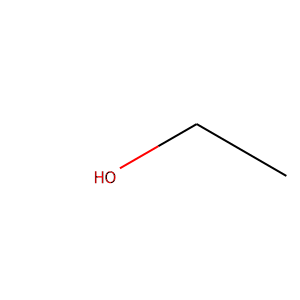

In [119]:
from IPython.display import SVG
from chembl_webresource_client.utils import utils

chembl_smiles = ethanol_chembl["molecule_structures"]["canonical_smiles"]

SVG(utils.smiles2svg(chembl_smiles))

In [6]:
#%pip install widget_periodictable
#https://github.com/osscar-org/widget-periodictable/
#!jupyter nbextension enable --py widget_periodictable
from widget_periodictable import PTableWidget

widget = PTableWidget(states = 3, selected_elements = {"C": 0, "Si": 1, "Ge": 2}, 
                      selected_colors = ['pink', 'yellow', 'lightblue'], 
                      disabled_elements = ['B', 'Al', 'Ga'],
                      unselected_color='white', border_color = 'black', width = '20px')
display(widget)

PTableWidget(allElements=['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', '…

The periodic table widget can return symbols for selected elements, which means we could use it as an interface element for an automated lookup of various properties of selected items.

We can also use code to control which elements in the table are highlighted, we means we could also highlight elements in the table that may have been identified through some other lookup service. For example, highlight all the elements in the table contained in a particular compound.

In [7]:
widget.selected_elements = {"La": 0, "Ce": 1, "Pr": 2}
# Does this all work if we eg pop the periodic table out into a floating widget?

In [53]:
#%pip install pypdb
#https://github.com/williamgilpin/pypdb/blob/master/demos/demos.ipynb
#A Python 3 toolkit for performing searches with the RCSB Protein Data Bank (PDB). 
import pypdb

pypdb.Query('nitroglycerin').search()

['4FR8',
 '4FQF',
 '2ONO',
 '2ONN',
 '2ONP',
 '2ONM',
 '2LDU',
 '5HDG',
 '5D5V',
 '5D5U',
 '3INJ',
 '3INL',
 '5HDN',
 '4PW8',
 '6UD5',
 '6VBN',
 '5TIA',
 '6PYZ',
 '6PYY',
 '6A4I',
 '5TI9']